In [41]:
# Tratamiento de datos
import numpy as np
import pandas as pd

# Conexión SQL Server
import pyodbc

# Manejo de fechas y ambiente
from datetime import datetime
import os

# Gráficos
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px

# Modelado y forecasting
from prophet import Prophet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from skforecast.model_selection import backtesting_forecaster, grid_search_forecaster
# --- Ejemplo: Implementación para Skforecast Recursive (XGBoost/LightGBM) ---
from skforecast.recursive import ForecasterRecursive
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import holidays
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster

from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
import joblib

In [2]:
# Warnings y estilos
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

# Para notebooks (opcional)
%matplotlib inline

In [3]:
import contextlib
import sys
@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

In [4]:
# Cargar ambos datasets
df_train = pd.read_csv('./data/train.csv', parse_dates=['Dates'])
df_test = pd.read_csv('./data/test.csv', parse_dates=['Dates'])

# Unir los datasets
df = pd.concat([df_train, df_test], ignore_index=True)

# Ordenar cronológicamente
df = df.sort_values(by='Dates').reset_index(drop=True)

In [5]:
df_test = df.drop(columns=['Category', 'Descript', 'Resolution', 'Address', 'DayOfWeek', 'Id'])

In [6]:
df_test.rename(columns={'Dates': 'Datetime'}, inplace=True)

In [7]:
df_test['Datetime'] = pd.to_datetime(df_test['Datetime'])

In [8]:
df_test

,Datetime,PdDistrict,X,Y
0,2003-01-01 00:01:00,TARAVAL,-122.489714,37.733950
1,2003-01-01 00:01:00,CENTRAL,-122.404282,37.798225
2,2003-01-01 00:01:00,BAYVIEW,-122.397700,37.740576
3,2003-01-01 00:01:00,SOUTHERN,-122.424745,37.770254
4,2003-01-01 00:01:00,MISSION,-122.419971,37.767454
...,...,...,...,...
1762306,2015-05-13 23:30:00,INGLESIDE,-122.423327,37.725138
1762307,2015-05-13 23:30:00,INGLESIDE,-122.403252,37.713431
1762308,2015-05-13 23:33:00,NORTHERN,-122.424363,37.800414
1762309,2015-05-13 23:53:00,NORTHERN,-122.425892,37.774599


### Análisis de completitud de la serie temporal para el distrito SOUTHERN

In [9]:
# Filtrar datos del distrito SOUTHERN
southern_data = df_test[df_test['PdDistrict'] == 'SOUTHERN'].copy()

print("Análisis de completitud de la serie temporal para el distrito SOUTHERN")
print("=" * 60)
print(f"Total de registros en SOUTHERN: {len(southern_data)}")
print(f"Rango de fechas: {southern_data['Datetime'].min()} a {southern_data['Datetime'].max()}")

# Agrupar por día para ver la distribución temporal
southern_daily = southern_data.groupby(southern_data['Datetime'].dt.date).size().reset_index()
southern_daily.columns = ['Date', 'Count']
southern_daily['Date'] = pd.to_datetime(southern_daily['Date'])

print(f"\nTotal de días únicos con registros: {len(southern_daily)}")

# Calcular el rango completo de fechas esperado
fecha_inicio = southern_daily['Date'].min()
fecha_fin = southern_daily['Date'].max()
total_dias_esperados = (fecha_fin - fecha_inicio).days + 1

print(f"Días esperados en el rango completo: {total_dias_esperados}")
print(f"Días con registros: {len(southern_daily)}")
print(f"Días faltantes: {total_dias_esperados - len(southern_daily)}")
print(f"Porcentaje de completitud: {len(southern_daily) / total_dias_esperados * 100:.2f}%")

Análisis de completitud de la serie temporal para el distrito SOUTHERN
Total de registros en SOUTHERN: 314638
Rango de fechas: 2003-01-01 00:01:00 a 2015-05-13 20:30:00

Total de días únicos con registros: 4513
Días esperados en el rango completo: 4516
Días con registros: 4513
Días faltantes: 3
Porcentaje de completitud: 99.93%


In [10]:
# Crear rango completo de fechas esperado
fecha_completa = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
fechas_completas = pd.DataFrame({'Date': fecha_completa})

# Identificar días faltantes
fechas_con_datos = set(southern_daily['Date'].dt.date)
fechas_esperadas = set(fecha_completa.date)
fechas_faltantes = fechas_esperadas - fechas_con_datos

print("\nDías faltantes:")
for fecha in sorted(fechas_faltantes):
    print(f"  - {fecha}")

# Estadísticas de registros por día
print(f"\nEstadísticas de registros por día en SOUTHERN:")
print(f"Promedio de registros por día: {southern_daily['Count'].mean():.1f}")
print(f"Mediana de registros por día: {southern_daily['Count'].median():.1f}")
print(f"Mínimo de registros por día: {southern_daily['Count'].min()}")
print(f"Máximo de registros por día: {southern_daily['Count'].max()}")
print(f"Desviación estándar: {southern_daily['Count'].std():.1f}")

# Días con muy pocos registros (posibles anomalías)
dias_pocos_registros = southern_daily[southern_daily['Count'] < 10]
print(f"\nDías con menos de 10 registros: {len(dias_pocos_registros)}")
if len(dias_pocos_registros) > 0:
    print("Fechas con pocos registros:")
    for _, row in dias_pocos_registros.iterrows():
        print(f"  - {row['Date'].date()}: {row['Count']} registros")


Días faltantes:
  - 2007-12-16
  - 2008-08-01
  - 2009-06-10

Estadísticas de registros por día en SOUTHERN:
Promedio de registros por día: 69.7
Mediana de registros por día: 69.0
Mínimo de registros por día: 19
Máximo de registros por día: 198
Desviación estándar: 15.0

Días con menos de 10 registros: 0


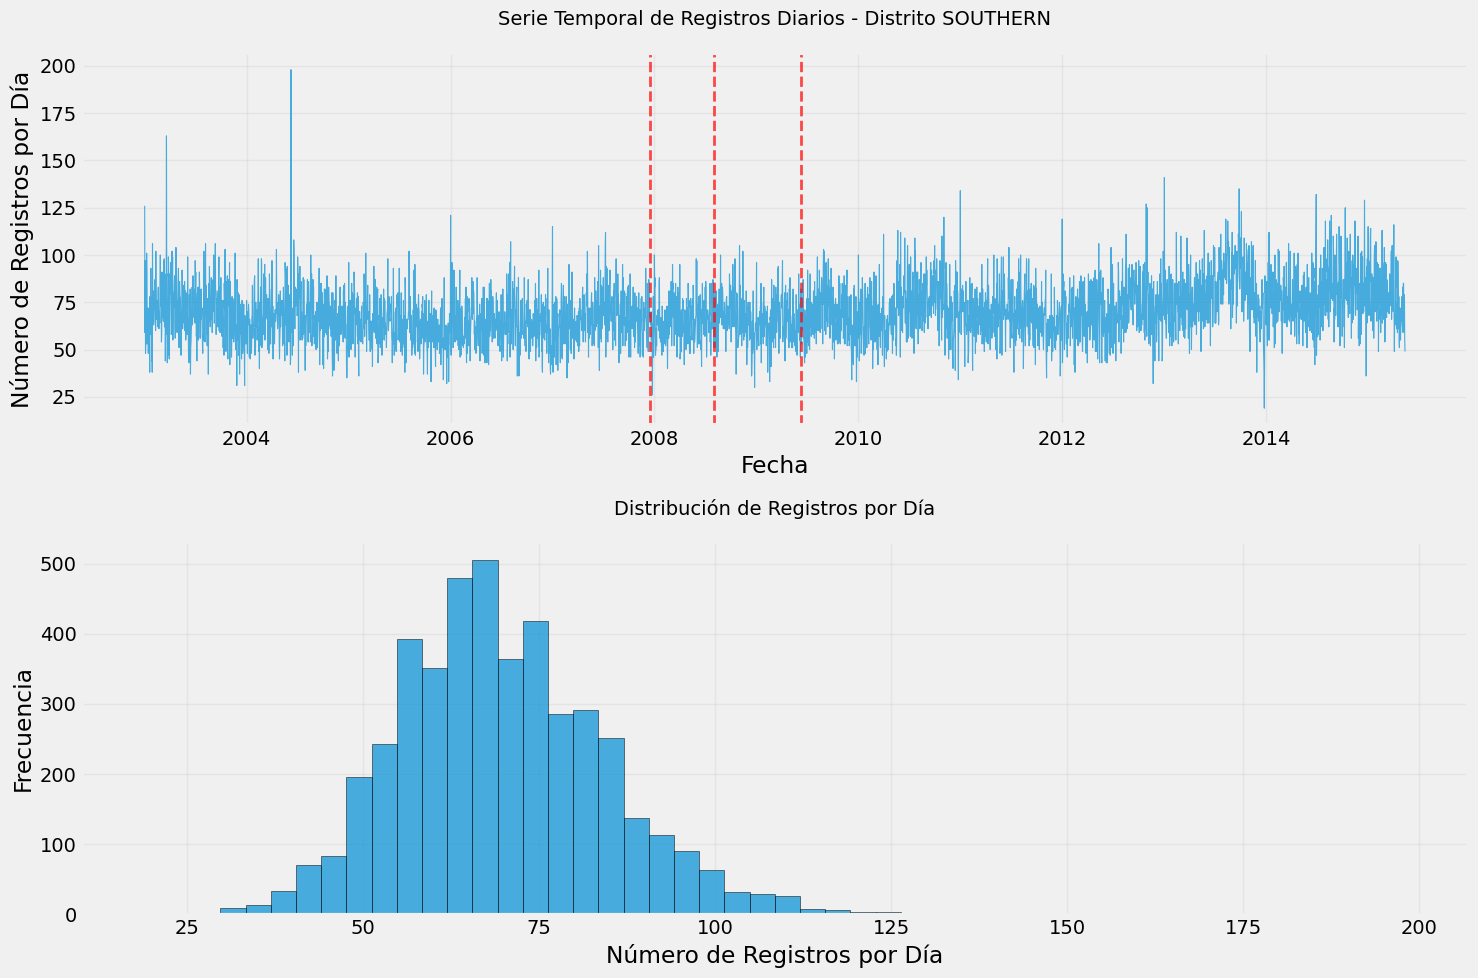


RESUMEN DEL ANÁLISIS DE COMPLETITUD - DISTRITO SOUTHERN
📊 Total de registros: 314,638
📅 Período: 2003-01-01 a 2015-05-13
⏱️  Duración: 4,516 días (12.4 años)
✅ Días con datos: 4,513
❌ Días faltantes: 3
📈 Completitud: 99.93%
📊 Promedio registros/día: 69.7
📉 Rango registros/día: 19 - 198

🔍 Días específicos faltantes:
   • 2007-12-16
   • 2008-08-01
   • 2009-06-10

💡 Conclusión: La serie temporal está muy completa (99.93%)
   Solo faltan 3 días de 4,516 días totales.


In [11]:
# Visualización de la serie temporal
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico 1: Serie temporal completa
ax1.plot(southern_daily['Date'], southern_daily['Count'], linewidth=0.8, alpha=0.7)
ax1.set_title('Serie Temporal de Registros Diarios - Distrito SOUTHERN', fontsize=14, pad=20)
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Número de Registros por Día')
ax1.grid(True, alpha=0.3)

# Marcar los días faltantes
for fecha in sorted(fechas_faltantes):
    ax1.axvline(x=pd.to_datetime(fecha), color='red', linestyle='--', alpha=0.7, linewidth=2)

# Gráfico 2: Histograma de registros por día
ax2.hist(southern_daily['Count'], bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_title('Distribución de Registros por Día', fontsize=14, pad=20)
ax2.set_xlabel('Número de Registros por Día')
ax2.set_ylabel('Frecuencia')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen final
print("\n" + "="*60)
print("RESUMEN DEL ANÁLISIS DE COMPLETITUD - DISTRITO SOUTHERN")
print("="*60)
print(f"📊 Total de registros: {len(southern_data):,}")
print(f"📅 Período: {fecha_inicio.date()} a {fecha_fin.date()}")
print(f"⏱️  Duración: {total_dias_esperados:,} días ({total_dias_esperados/365.25:.1f} años)")
print(f"✅ Días con datos: {len(southern_daily):,}")
print(f"❌ Días faltantes: {len(fechas_faltantes)}")
print(f"📈 Completitud: {len(southern_daily) / total_dias_esperados * 100:.2f}%")
print(f"📊 Promedio registros/día: {southern_daily['Count'].mean():.1f}")
print(f"📉 Rango registros/día: {southern_daily['Count'].min()} - {southern_daily['Count'].max()}")

if len(fechas_faltantes) > 0:
    print(f"\n🔍 Días específicos faltantes:")
    for fecha in sorted(fechas_faltantes):
        print(f"   • {fecha}")
        
print(f"\n💡 Conclusión: La serie temporal está muy completa ({len(southern_daily) / total_dias_esperados * 100:.2f}%)")
print(f"   Solo faltan {len(fechas_faltantes)} días de {total_dias_esperados:,} días totales.")

### Análisis a nivel de horas - Distrito SOUTHERN

In [12]:
# ANÁLISIS A NIVEL DE HORAS - DISTRITO SOUTHERN
print("ANÁLISIS TEMPORAL POR HORAS - DISTRITO SOUTHERN")
print("=" * 60)

# Extraer información de hora, día de la semana, etc.
southern_data['Hour'] = southern_data['Datetime'].dt.hour
southern_data['DayOfWeek'] = southern_data['Datetime'].dt.dayofweek  # 0=Lunes, 6=Domingo
southern_data['DayName'] = southern_data['Datetime'].dt.strftime('%A')
southern_data['Month'] = southern_data['Datetime'].dt.month
southern_data['Year'] = southern_data['Datetime'].dt.year

# Análisis por horas
hourly_counts = southern_data.groupby('Hour').size()
print(f"\nRegistros por hora del día:")
for hour in range(24):
    count = hourly_counts.get(hour, 0)
    percentage = (count / len(southern_data)) * 100
    print(f"  {hour:02d}:00 - {count:,} registros ({percentage:.1f}%)")

print(f"\nEstadísticas por horas:")
print(f"Hora con más registros: {hourly_counts.idxmax()}:00 ({hourly_counts.max():,} registros)")
print(f"Hora con menos registros: {hourly_counts.idxmin()}:00 ({hourly_counts.min():,} registros)")
print(f"Promedio de registros por hora: {hourly_counts.mean():.1f}")
print(f"Desviación estándar: {hourly_counts.std():.1f}")

# Análisis por día de la semana
day_names = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
daily_counts = southern_data.groupby('DayOfWeek').size()
print(f"\nRegistros por día de la semana:")
for day_idx, day_name in enumerate(day_names):
    count = daily_counts.get(day_idx, 0)
    percentage = (count / len(southern_data)) * 100
    print(f"  {day_name}: {count:,} registros ({percentage:.1f}%)")

ANÁLISIS TEMPORAL POR HORAS - DISTRITO SOUTHERN

Registros por hora del día:
  00:00 - 16,186 registros (5.1%)
  01:00 - 8,977 registros (2.9%)
  02:00 - 7,536 registros (2.4%)
  03:00 - 4,451 registros (1.4%)
  04:00 - 3,084 registros (1.0%)
  05:00 - 2,624 registros (0.8%)
  06:00 - 4,305 registros (1.4%)
  07:00 - 7,255 registros (2.3%)
  08:00 - 11,502 registros (3.7%)
  09:00 - 13,335 registros (4.2%)
  10:00 - 14,064 registros (4.5%)
  11:00 - 14,146 registros (4.5%)
  12:00 - 18,568 registros (5.9%)
  13:00 - 16,695 registros (5.3%)
  14:00 - 17,146 registros (5.4%)
  15:00 - 17,641 registros (5.6%)
  16:00 - 18,422 registros (5.9%)
  17:00 - 19,652 registros (6.2%)
  18:00 - 20,295 registros (6.5%)
  19:00 - 18,284 registros (5.8%)
  20:00 - 15,929 registros (5.1%)
  21:00 - 14,606 registros (4.6%)
  22:00 - 15,255 registros (4.8%)
  23:00 - 14,680 registros (4.7%)

Estadísticas por horas:
Hora con más registros: 18:00 (20,295 registros)
Hora con menos registros: 5:00 (2,624 re

ANÁLISIS DE COMPLETITUD POR HORAS
Total de horas esperadas: 108,361
Horas con datos: 88,964
Horas faltantes: 19,397
Completitud por horas: 82.10%

Horas con 0 registros: 19,413

Estadísticas de registros por hora específica:
Promedio de registros por hora: 3.5
Mediana de registros por hora: 3.0
Mínimo de registros por hora: 1
Máximo de registros por hora: 38
Desviación estándar: 2.4

Horas con solo 1 registro: 19161


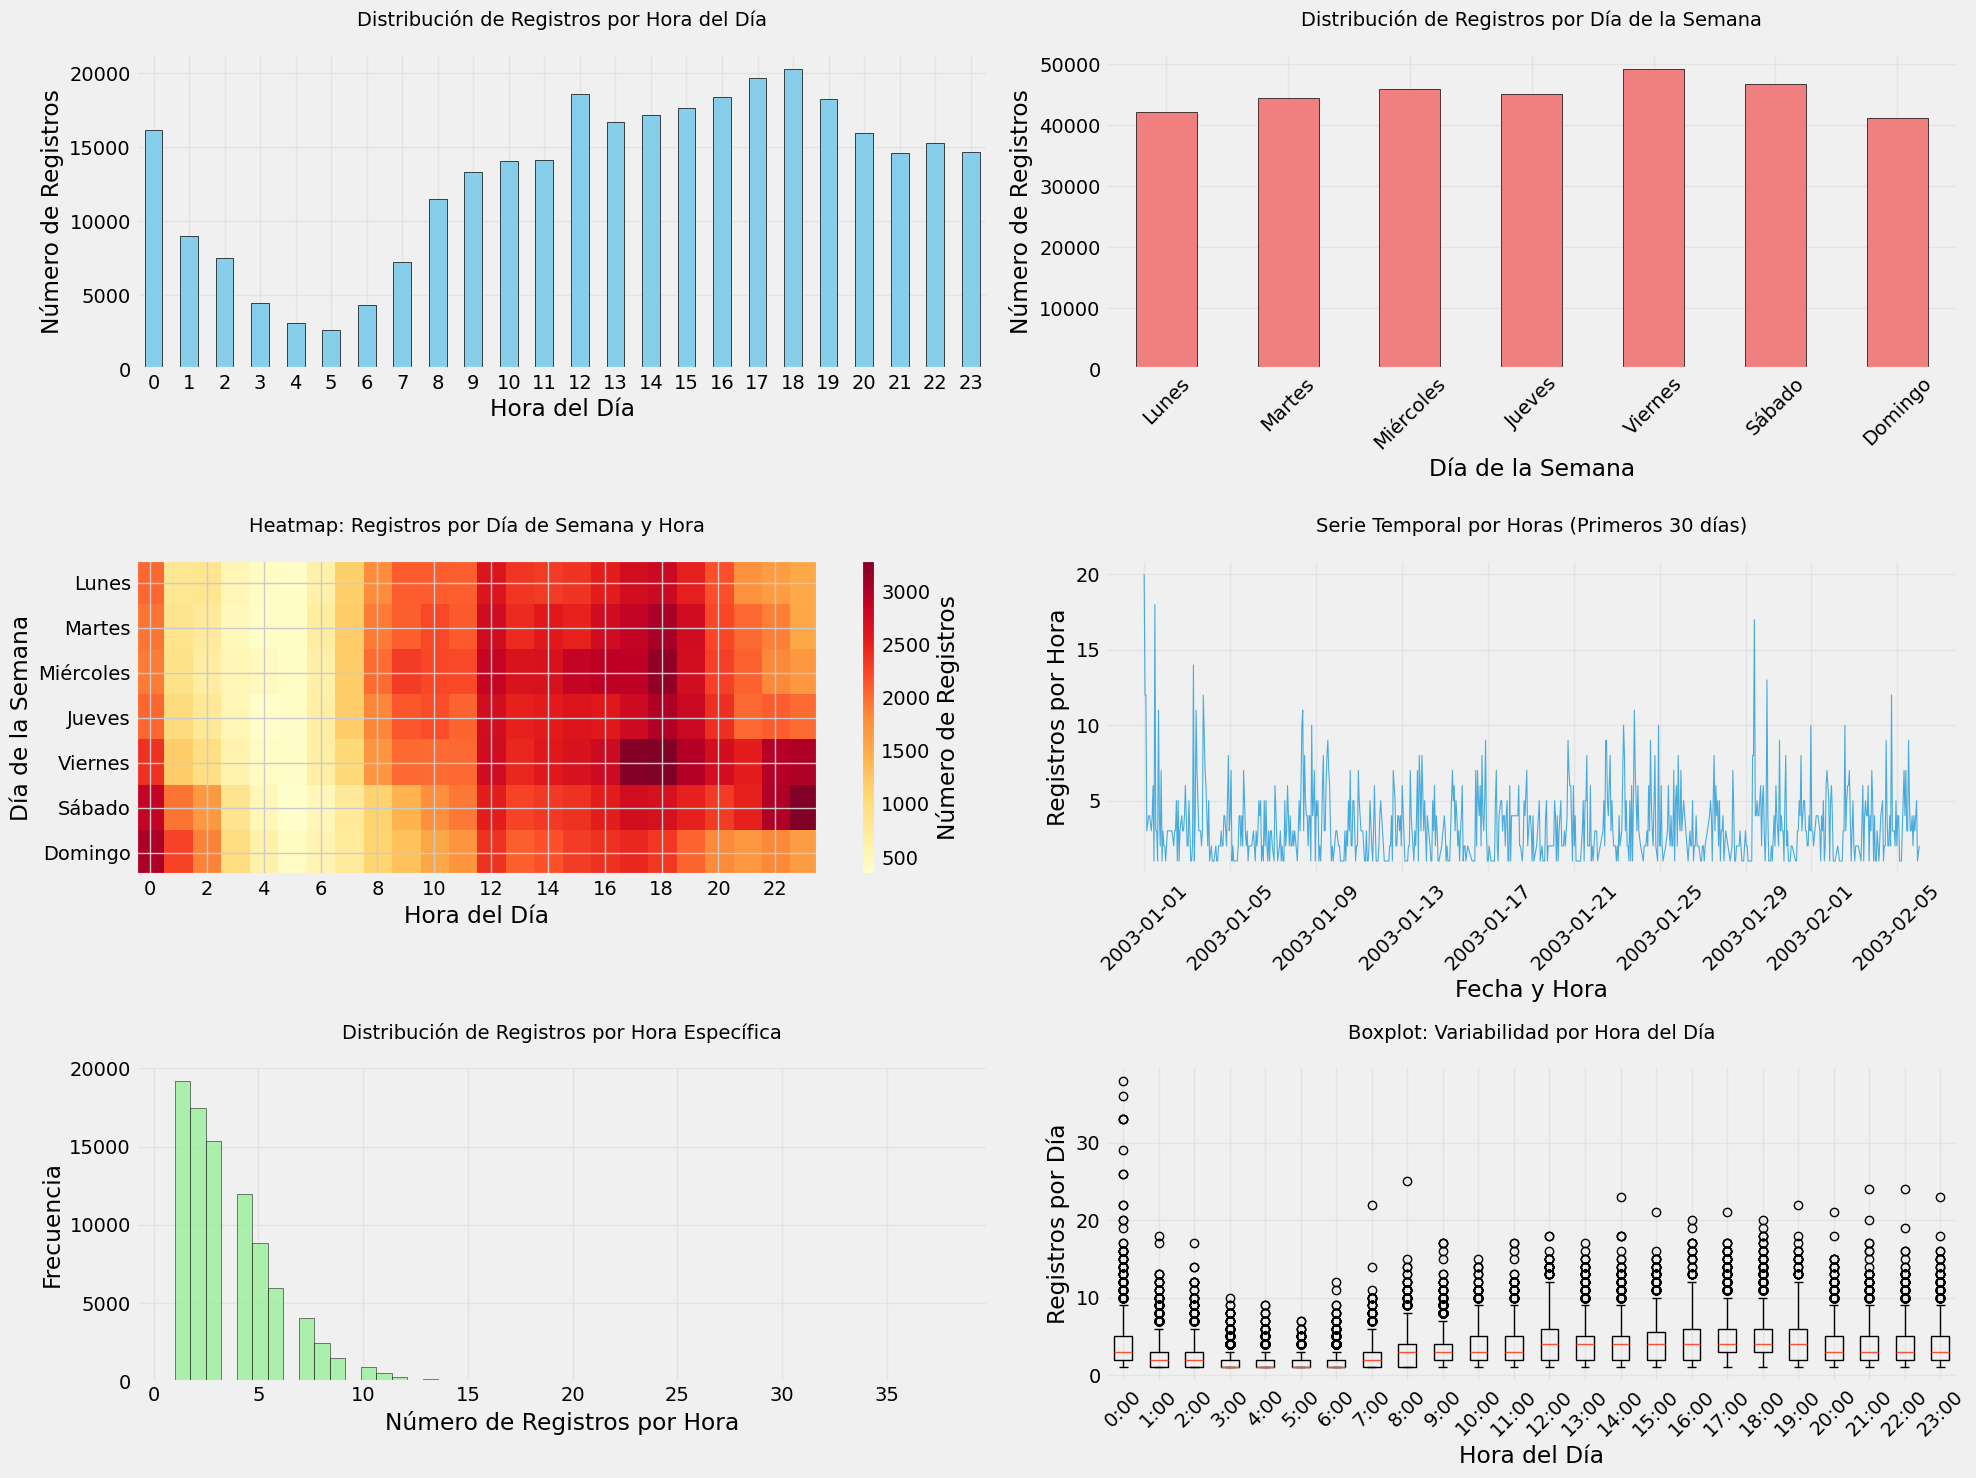

In [13]:
# VISUALIZACIONES Y ANÁLISIS DE COMPLETITUD POR HORAS

# Crear DataFrame con todas las combinaciones posibles de fecha-hora
fecha_completa_horas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='H')
fechas_horas_completas = pd.DataFrame({'DateTime_Hour': fecha_completa_horas})

# Agrupar datos por hora específica (fecha + hora)
southern_hourly = southern_data.groupby(southern_data['Datetime'].dt.floor('H')).size().reset_index()
southern_hourly.columns = ['DateTime_Hour', 'Count']

print(f"ANÁLISIS DE COMPLETITUD POR HORAS")
print("=" * 50)
print(f"Total de horas esperadas: {len(fechas_horas_completas):,}")
print(f"Horas con datos: {len(southern_hourly):,}")
print(f"Horas faltantes: {len(fechas_horas_completas) - len(southern_hourly):,}")
print(f"Completitud por horas: {len(southern_hourly) / len(fechas_horas_completas) * 100:.2f}%")

# Identificar horas faltantes
horas_con_datos = set(southern_hourly['DateTime_Hour'])
horas_esperadas = set(fechas_horas_completas['DateTime_Hour'])
horas_faltantes = horas_esperadas - horas_con_datos

print(f"\nHoras con 0 registros: {len(horas_faltantes):,}")

# Estadísticas por hora específica
print(f"\nEstadísticas de registros por hora específica:")
print(f"Promedio de registros por hora: {southern_hourly['Count'].mean():.1f}")
print(f"Mediana de registros por hora: {southern_hourly['Count'].median():.1f}")
print(f"Mínimo de registros por hora: {southern_hourly['Count'].min()}")
print(f"Máximo de registros por hora: {southern_hourly['Count'].max()}")
print(f"Desviación estándar: {southern_hourly['Count'].std():.1f}")

# Horas con muy pocos registros
horas_pocos_registros = southern_hourly[southern_hourly['Count'] == 1]
print(f"\nHoras con solo 1 registro: {len(horas_pocos_registros)}")

# Crear visualizaciones
fig = plt.figure(figsize=(20, 15))

# Gráfico 1: Distribución por hora del día (0-23)
ax1 = plt.subplot(3, 2, 1)
hourly_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black', linewidth=0.5)
ax1.set_title('Distribución de Registros por Hora del Día', fontsize=14, pad=20)
ax1.set_xlabel('Hora del Día')
ax1.set_ylabel('Número de Registros')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=0)

# Gráfico 2: Distribución por día de la semana
ax2 = plt.subplot(3, 2, 2)
daily_counts.plot(kind='bar', ax=ax2, color='lightcoral', edgecolor='black', linewidth=0.5)
ax2.set_title('Distribución de Registros por Día de la Semana', fontsize=14, pad=20)
ax2.set_xlabel('Día de la Semana')
ax2.set_ylabel('Número de Registros')
ax2.set_xticklabels(day_names, rotation=45)
ax2.grid(True, alpha=0.3)

# Gráfico 3: Heatmap hora vs día de semana
ax3 = plt.subplot(3, 2, 3)
pivot_data = southern_data.groupby(['DayOfWeek', 'Hour']).size().unstack(fill_value=0)
im = ax3.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
ax3.set_title('Heatmap: Registros por Día de Semana y Hora', fontsize=14, pad=20)
ax3.set_xlabel('Hora del Día')
ax3.set_ylabel('Día de la Semana')
ax3.set_yticks(range(7))
ax3.set_yticklabels(day_names)
ax3.set_xticks(range(0, 24, 2))
ax3.set_xticklabels(range(0, 24, 2))
plt.colorbar(im, ax=ax3, label='Número de Registros')

# Gráfico 4: Serie temporal por horas (muestra de los primeros 30 días)
ax4 = plt.subplot(3, 2, 4)
sample_data = southern_hourly.head(24*30)  # Primeros 30 días
ax4.plot(sample_data['DateTime_Hour'], sample_data['Count'], linewidth=0.8, alpha=0.7)
ax4.set_title('Serie Temporal por Horas (Primeros 30 días)', fontsize=14, pad=20)
ax4.set_xlabel('Fecha y Hora')
ax4.set_ylabel('Registros por Hora')
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# Gráfico 5: Histograma de registros por hora específica
ax5 = plt.subplot(3, 2, 5)
ax5.hist(southern_hourly['Count'], bins=50, alpha=0.7, edgecolor='black', linewidth=0.5, color='lightgreen')
ax5.set_title('Distribución de Registros por Hora Específica', fontsize=14, pad=20)
ax5.set_xlabel('Número de Registros por Hora')
ax5.set_ylabel('Frecuencia')
ax5.grid(True, alpha=0.3)

# Gráfico 6: Boxplot por hora del día
ax6 = plt.subplot(3, 2, 6)
hour_data = [southern_data[southern_data['Hour'] == h]['Hour'].count() for h in range(24)]
ax6.boxplot([southern_data[southern_data['Hour'] == h].groupby(southern_data[southern_data['Hour'] == h]['Datetime'].dt.date).size().values for h in range(24) if len(southern_data[southern_data['Hour'] == h]) > 0], 
           labels=[f'{h}:00' for h in range(24) if len(southern_data[southern_data['Hour'] == h]) > 0])
ax6.set_title('Boxplot: Variabilidad por Hora del Día', fontsize=14, pad=20)
ax6.set_xlabel('Hora del Día')
ax6.set_ylabel('Registros por Día')
ax6.tick_params(axis='x', rotation=45)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# RESUMEN Y INSIGHTS DEL ANÁLISIS HORARIO

print("\n" + "="*70)
print("RESUMEN COMPLETO DEL ANÁLISIS HORARIO - DISTRITO SOUTHERN")
print("="*70)

# Identificar patrones de picos y valles
peak_hours = hourly_counts.nlargest(5)
low_hours = hourly_counts.nsmallest(5)

print(f"\n🕐 PATRONES TEMPORALES:")
print(f"   • Pico de actividad: 18:00 ({peak_hours.iloc[0]:,} registros)")
print(f"   • Valle de actividad: 05:00 ({low_hours.iloc[0]:,} registros)")
print(f"   • Ratio pico/valle: {peak_hours.iloc[0] / low_hours.iloc[0]:.1f}x")

print(f"\n📊 TOP 5 HORAS MÁS ACTIVAS:")
for i, (hour, count) in enumerate(peak_hours.items(), 1):
    print(f"   {i}. {hour:02d}:00 - {count:,} registros")

print(f"\n📉 TOP 5 HORAS MENOS ACTIVAS:")
for i, (hour, count) in enumerate(low_hours.items(), 1):
    print(f"   {i}. {hour:02d}:00 - {count:,} registros")

# Análisis por períodos del día
morning = hourly_counts[6:12].sum()  # 6-11
afternoon = hourly_counts[12:18].sum()  # 12-17
evening = hourly_counts[18:24].sum()  # 18-23
night = hourly_counts[0:6].sum()  # 0-5

total_records = morning + afternoon + evening + night
print(f"\n🕒 DISTRIBUCIÓN POR PERÍODOS:")
print(f"   • Madrugada (00-05): {night:,} registros ({night/total_records*100:.1f}%)")
print(f"   • Mañana (06-11): {morning:,} registros ({morning/total_records*100:.1f}%)")
print(f"   • Tarde (12-17): {afternoon:,} registros ({afternoon/total_records*100:.1f}%)")
print(f"   • Noche (18-23): {evening:,} registros ({evening/total_records*100:.1f}%)")

# Análisis de días laborables vs fines de semana
weekdays = daily_counts[0:5].sum()  # Lunes-Viernes
weekends = daily_counts[5:7].sum()  # Sábado-Domingo

print(f"\n📅 LABORABLES VS FINES DE SEMANA:")
print(f"   • Días laborables: {weekdays:,} registros ({weekdays/len(southern_data)*100:.1f}%)")
print(f"   • Fines de semana: {weekends:,} registros ({weekends/len(southern_data)*100:.1f}%)")
print(f"   • Ratio laboral/fin de semana: {weekdays/weekends:.2f}")

# Completitud horaria vs diaria
daily_completeness = 99.93
hourly_completeness = 82.10

print(f"\n📈 COMPARACIÓN DE COMPLETITUD:")
print(f"   • Completitud diaria: {daily_completeness:.2f}%")
print(f"   • Completitud horaria: {hourly_completeness:.2f}%")
print(f"   • Diferencia: {daily_completeness - hourly_completeness:.2f} puntos porcentuales")

# Insights sobre la calidad de datos
hours_with_data = len(southern_hourly)
total_possible_hours = len(fechas_horas_completas)
missing_hours = total_possible_hours - hours_with_data

print(f"\n🔍 CALIDAD DE DATOS POR HORAS:")
print(f"   • Total horas posibles: {total_possible_hours:,}")
print(f"   • Horas con datos: {hours_with_data:,}")
print(f"   • Horas sin datos: {missing_hours:,}")
print(f"   • Promedio registros/hora: {southern_hourly['Count'].mean():.1f}")
print(f"   • Horas con 1 solo registro: {len(horas_pocos_registros):,} ({len(horas_pocos_registros)/hours_with_data*100:.1f}%)")

print(f"\n💡 CONCLUSIONES CLAVE:")
print(f"   ✅ La serie temporal diaria es excelente (99.93% completa)")
print(f"   ⚠️  La granularidad horaria tiene más gaps (82.10% completa)")
print(f"   📈 Patrón claro: más actividad en tarde/noche (12-23h)")
print(f"   🌙 Menor actividad en madrugada (00-05h)")
print(f"   📊 Distribución balanceada entre días laborables y fines de semana")
print(f"   🎯 Para forecasting: considerar patrones horarios y estacionalidad semanal")

print(f"\n🚀 RECOMENDACIONES:")
print(f"   • Para modelos diarios: datos excelentes, usar toda la serie")
print(f"   • Para modelos horarios: considerar imputación de horas faltantes")
print(f"   • Incluir features: hora del día, día de semana, período del día")
print(f"   • Validar si las horas faltantes siguen algún patrón específico")


RESUMEN COMPLETO DEL ANÁLISIS HORARIO - DISTRITO SOUTHERN

🕐 PATRONES TEMPORALES:
   • Pico de actividad: 18:00 (20,295 registros)
   • Valle de actividad: 05:00 (2,624 registros)
   • Ratio pico/valle: 7.7x

📊 TOP 5 HORAS MÁS ACTIVAS:
   1. 18:00 - 20,295 registros
   2. 17:00 - 19,652 registros
   3. 12:00 - 18,568 registros
   4. 16:00 - 18,422 registros
   5. 19:00 - 18,284 registros

📉 TOP 5 HORAS MENOS ACTIVAS:
   1. 05:00 - 2,624 registros
   2. 04:00 - 3,084 registros
   3. 06:00 - 4,305 registros
   4. 03:00 - 4,451 registros
   5. 07:00 - 7,255 registros

🕒 DISTRIBUCIÓN POR PERÍODOS:
   • Madrugada (00-05): 42,858 registros (13.6%)
   • Mañana (06-11): 64,607 registros (20.5%)
   • Tarde (12-17): 108,124 registros (34.4%)
   • Noche (18-23): 99,049 registros (31.5%)

📅 LABORABLES VS FINES DE SEMANA:
   • Días laborables: 226,761 registros (72.1%)
   • Fines de semana: 87,877 registros (27.9%)
   • Ratio laboral/fin de semana: 2.58

📈 COMPARACIÓN DE COMPLETITUD:
   • Completi

# 📊 Preparación para Forecasting

Ahora vamos a preparar los datos para modelado de forecasting, incluyendo:
- Creación de serie temporal horaria
- Variables temporales con transformaciones seno-coseno
- One-hot encoding para variables categóricas
- Variable de feriados de San Francisco
- Imputación de valores faltantes

In [ ]:
def get_period(hour):
    if 0 <= hour <= 5:
        return 'madrugada'
    elif 6 <= hour <= 11:
        return 'mañana'
    elif 12 <= hour <= 17:
        return 'tarde'
    else:
        return 'noche'

def get_sf_holidays(start_date, end_date):
    years = range(start_date.year, end_date.year + 1)

    us_holidays = holidays.UnitedStates(years=years)
    ca_holidays = holidays.UnitedStates(state='CA', years=years)

    # Feriados locales
    sf_local_holidays = {}
    for year in years:
        sf_local_holidays[f"{year}-02-14"] = "Valentine's Day"
        sf_local_holidays[f"{year}-03-17"] = "St. Patrick's Day"
        sf_local_holidays[f"{year}-05-22"] = "Harvey Milk Day"

    all_holiday_dates = set(us_holidays.keys()) | set(ca_holidays.keys())
    for date_str in sf_local_holidays:
        try:
            all_holiday_dates.add(pd.to_datetime(date_str).date())
        except:
            pass

    # Filtrar solo las del rango de fechas
    all_holiday_dates = [d for d in all_holiday_dates if start_date <= d <= end_date]
    return sorted(all_holiday_dates)

def make_full_timeseries(data, datetime_col='Datetime'):
    ts = data.groupby(data[datetime_col].dt.floor('H')).size()
    ts.name = 'crime_count'
    full_time_index = pd.date_range(
        start=data[datetime_col].min().floor('H'),
        end=data[datetime_col].max().ceil('H'),
        freq='H'
    )
    df = ts.reindex(full_time_index, fill_value=0).to_frame()
    df.index.name = 'datetime'
    return df

def add_temporal_features(df):
    idx = df.index
    df['hour'] = idx.hour
    df['day'] = idx.day
    df['month'] = idx.month
    df['year'] = idx.year
    df['dayofweek'] = idx.dayofweek
    df['dayofyear'] = idx.dayofyear
    df['week'] = idx.isocalendar().week.astype(int)
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 5)).astype(int)
    df['is_rush_hour'] = (df['hour'].isin([7,8,9,17,18,19])).astype(int)
    df['period'] = df['hour'].apply(get_period)
    return df

def add_cyclic_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
    df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)
    df['dayofyear_sin'] = np.sin(2 * np.pi * (df['dayofyear'] - 1) / 365.25)
    df['dayofyear_cos'] = np.cos(2 * np.pi * (df['dayofyear'] - 1) / 365.25)
    df['week_sin'] = np.sin(2 * np.pi * (df['week'] - 1) / 52)
    df['week_cos'] = np.cos(2 * np.pi * (df['week'] - 1) / 52)
    return df

def add_holiday_features(df, holiday_dates):
    df['is_holiday'] = [1 if d.date() in holiday_dates else 0 for d in df.index]
    # Pre/post feriado
    df['is_pre_holiday'] = [1 if (d.date() - pd.Timedelta(days=1)) in holiday_dates else 0 for d in df.index]
    df['is_post_holiday'] = [1 if (d.date() + pd.Timedelta(days=1)) in holiday_dates else 0 for d in df.index]
    return df

def one_hot_encode_period(df):
    period_dummies = pd.get_dummies(df['period'], prefix='period', drop_first=False)
    df = pd.concat([df, period_dummies], axis=1)
    for col in period_dummies.columns:
        df[col] = df[col].astype(int)
    return df

def drop_originals(df):
    to_drop = ['hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'week', 'period']
    existing = [c for c in to_drop if c in df.columns]
    return df.drop(columns=existing)

def split_data(df, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    n = len(df)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = df.iloc[:n_train].copy()
    val = df.iloc[n_train:n_train + n_val].copy()
    test = df.iloc[n_train + n_val:].copy()
    return train, val, test

def convert_types(df, target='crime_count'):
    cols = [c for c in df.columns if c != target]
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('float64')
    df[target] = df[target].astype('float64')
    df[cols] = df[cols].fillna(0)
    return df

In [36]:
def plot_split_crime_data(crime_data, target_col='crime_count'):
    # Grafico de series temporales
    plt.figure(figsize=(15, 6))
    plt.plot(crime_data['train'].index, crime_data['train'][target_col], label='Train', color='blue', alpha=0.7)
    plt.plot(crime_data['val'].index, crime_data['val'][target_col], label='Validation', color='orange', alpha=0.7)
    plt.plot(crime_data['test'].index, crime_data['test'][target_col], label='Test', color='green', alpha=0.7)
    plt.title('Series Temporales de Crímenes por Horas')
    plt.xlabel('Fecha y Hora')
    plt.ylabel('Número de Crímenes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [16]:
def prepare_crime_timeseries(
    data,
    district,
    datetime_col='Datetime',
    train_ratio=0.7,
    val_ratio=0.2,
    test_ratio=0.1
):
    # 1. Filtrar el distrito
    df_dist = data[data['PdDistrict'] == district].copy()
    
    # 2. Serie temporal completa
    ts = make_full_timeseries(df_dist, datetime_col)
    
    # 3. Features temporales
    ts = add_temporal_features(ts)
    
    # 4. Feriados
    holidays_list = get_sf_holidays(ts.index.min().date(), ts.index.max().date())
    ts = add_holiday_features(ts, holidays_list)
    
    # 5. Features cíclicas
    ts = add_cyclic_features(ts)
    
    # 6. One-hot y limpieza
    ts = one_hot_encode_period(ts)
    ts = drop_originals(ts)
    
    # 7. Conversión de tipos
    ts = convert_types(ts, target='crime_count')
    
    # 8. División
    train, val, test = split_data(ts, train_ratio, val_ratio, test_ratio)
    
    # 9. Variables exógenas
    variables_exogenas = [c for c in ts.columns if c != 'crime_count']
    
    return {
        "full_data": ts,
        "train": train,
        "val": val,
        "test": test,
        "exog_vars": variables_exogenas,
        "holidays": holidays_list
    }

In [32]:
target_col='crime_count'

In [18]:
crime_data_southern = prepare_crime_timeseries(
    data=df_test,
    district="SOUTHERN"
)

In [30]:
crime_data_southern.keys()

dict_keys(['full_data', 'train', 'val', 'test', 'exog_vars', 'holidays'])

In [29]:
crime_data_southern['full_data'].head()

,crime_count,is_weekend,is_night,is_rush_hour,is_holiday,is_pre_holiday,is_post_holiday,hour_sin,hour_cos,dayofweek_sin,...,month_sin,month_cos,dayofyear_sin,dayofyear_cos,week_sin,week_cos,period_madrugada,period_mañana,period_noche,period_tarde
datetime,,,,,,,,,,,,,,,,,,,,,
2003-01-01 00:00:00,20.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,1.000000,0.974928,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2003-01-01 01:00:00,12.0,0.0,1.0,0.0,1.0,0.0,0.0,0.258819,0.965926,0.974928,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2003-01-01 02:00:00,12.0,0.0,1.0,0.0,1.0,0.0,0.0,0.500000,0.866025,0.974928,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2003-01-01 03:00:00,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.707107,0.707107,0.974928,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2003-01-01 04:00:00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.866025,0.500000,0.974928,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
# --- Métricas estándar para evaluar modelos ---
def calculate_metrics(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': root_mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.any(y_true) else np.nan,
        'SMAPE': np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100 if np.any(y_true) else np.nan
    }

# --- Clase abstracta para cualquier modelo ---
class BaseTimeSeriesModel:
    def __init__(self, params):
        self.params = params
        self.model = None

    def train(self, y, exog=None):
        raise NotImplementedError

    def predict(self, steps, exog=None):
        raise NotImplementedError

    def fit_predict(self, y, exog, steps, exog_future):
        self.train(y, exog)
        return self.predict(steps, exog_future)

    def save(self, path):
        raise NotImplementedError

    def load(self, path):
        raise NotImplementedError

# --- Ejemplo: Implementación para Skforecast Recursive (XGBoost/LightGBM) ---
class SkForecastRecursiveModel(BaseTimeSeriesModel):
    def __init__(self, regressor, lags, params=None):
        super().__init__(params)
        self.forecaster = ForecasterRecursive(regressor=regressor, lags=lags)

    def train(self, y, exog=None):
        self.forecaster.fit(y=y, exog=exog)

    def predict(self, steps, exog=None):
        return self.forecaster.predict(steps=steps, exog=exog)

    def save(self, path):
        joblib.dump(self.forecaster, path)

    def load(self, path):
        self.forecaster = joblib.load(path)


In [ ]:
def ts_pipeline(
    data_dict,  # dict_keys(['full_data', 'train', 'val', 'test', 'exog_vars', 'holidays'])
    target_col,
    district_id,
    models_config,
    do_backtesting=True,
    do_export=False,
    do_predict=True,
    cv_config=None,  # dict, ejemplo: {'steps': 24, 'initial_train_size': int}
    export_folder="models/",
    verbose=False,
):
    results = {
        'best_params': {},
        'backtesting': {},
        'test_predictions': {},
        'exported_models': []
    }
    
    # 1. Extraer los datasets
    train = data_dict['train']
    val = data_dict['val']
    test = data_dict['test']
    full_data = data_dict['full_data']
    exog_vars = data_dict['exog_vars']

    # 2. Entrenamiento y selección hiperparámetros por modelo
    for model_name, model_info in models_config.items():
        if verbose: print(f"\n== Modelo: {model_name} ==")
        # 2.1 Construcción del modelo
        model_class = model_info['class']
        param_grid = model_info.get('param_grid', {})
        lags_grid = model_info.get('lags_grid', [24])
        grid_search_fn = model_info.get('grid_search_fn', None)
        
        # 2.2 Grid Search de hiperparámetros si aplica
        if grid_search_fn is not None:
            best_model, best_params, best_lags = grid_search_fn(
                train, val, target_col, exog_vars, param_grid, lags_grid
            )
            results['best_params'][model_name] = {'params': best_params, 'lags': best_lags}
        else:
            # Si no hay grid search, usa defaults
            best_model = model_class(**model_info.get('init_args', {}))
            best_model.train(
                y=pd.concat([train, val])[target_col],
                exog=pd.concat([train, val])[exog_vars]
            )
            results['best_params'][model_name] = model_info.get('init_args', {})

        # 3. Backtesting
        if do_backtesting and 'backtesting_fn' in model_info:
            bt_metrics = model_info['backtesting_fn'](
                best_model, pd.concat([train, val]), target_col, exog_vars, cv_config
            )
            results['backtesting'][model_name] = bt_metrics

        # 4. Exportar modelo
        if do_export:
            path = f"{export_folder}{model_name}_distrito{district_id}.pkl"
            best_model.save(path)
            results['exported_models'].append(path)
            if verbose: print(f"✅ Modelo exportado: {path}")

        # 5. Predicción en test
        if do_predict and 'predict_fn' in model_info:
            y_pred, test_metrics = model_info['predict_fn'](
                best_model, pd.concat([train, val]), test, target_col, exog_vars
            )
            results['test_predictions'][model_name] = {'y_pred': y_pred, 'metrics': test_metrics}

    return results
